# Gaussian Wake Deficit Models

This notebook reproduces the results of several papers presenting different versions of Gaussian wake models. They are presented in order of their publication dates.
    
Whilst PyWake defines wake models very generalisticly, some PyWake wind farm models have been defined to reproduce how they were originally published. For the Gaussian wake models these can be found in `py_wake/literature/gaussian_models.py`. That script is also a good starting point to check how you can setup your own Gaussian wind farm model. 

In [1]:
%load_ext autoreload
%autoreload 2

# install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

# import general
import numpy as np
import matplotlib.pyplot as plt
import os

## Bastankhah and Porté-Agel (2014)

This section reproduces results from 

Bastankhah M and Porté-Agel F.: _A new analytical model for wind-turbine wakes_, J. Renew. Energy., 70:116-23, (2014), https://doi.org/10.1016/j.renene.2014.01.002

This paper presents a general definition of a wake model with Gaussian profile shape that obeys momentum conservation for an isolated turbine and can be seen as the foundation of the Gaussain wake model family. All subsequent model developments are based on the assumptions defined within this paper.   

### Site and wind turbine

Define dummy wind turbine with fixed $C_T$ and simple site. We basically define a $C_T$ curve that is constant by setting the values at very large and low wind speed. Power is not needed, therefore it is set to zero. The site is needed in the simulation but it has no influence on the computed deficit, as the deficit is substracted from the background mean-flow. The deficit model does not respond to changes in turbulence intensity. 

In [2]:
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake.site._site import UniformSite

class Dummy(WindTurbine):
    def __init__(self, name='dummy', ct=0.8, d=80., zh=70.):
        WindTurbine.__init__(self, name=name, diameter=d,
                             hub_height=zh, powerCtFunction=PowerCtTabular([-100, 100], [0, 0], 'kW', [ct, ct]))

class BastankhahSite(UniformSite):
    def __init__(self, ws=10., ti=0.04):
        UniformSite.__init__(self, ti=ti, ws=ws)

### Wind farm model

The paper is not really defining a wind farm model at all, but only a deficit model. However, in PyWake we need to define these to simulate wake flows, thus we defined a literature model that uses some reasonable presets, which is loaded here.

Note that this model requires the user to input the wake expansion factor, $k$ (called $k^*$ in the paper).

In [3]:
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014

### Validation

To validate our implementation we choose to compare data from Fig.7 of the paper, as this tests the wake shape, wake expansion and centre line deficit at the same time. Only wake profiles will be compared, as they provide the most quantitative comparison. Here we limit it to cases 2 and 3, computed at $x/D = [3, 5]$, where $D$ is the rotor diameter and $x$ the downstream distance from the rotor plane. This is sufficient to demonstrate that the model is implemented correctly.

The inputs for the simulation are taken from Table 1 and Fig. 7. Table 1 provides wind turbine and inflow parameters (shear is not needed, for reasons mentioned before) and Fig. 4 provides the wake expansion factors for each case that were fitted to LES data. Note that the initial wake size, $\epsilon$, is not taken from Fig. 4, but computed as defined in the paper in Eq.(21) using $0.2 \sqrt{\beta}$.  

**Case definition**

In [4]:
# expansion factors (taken from Fig.4)
ks = [0.055, 0.040]
# hub height wind speed
ws = 9.
# rotor diameter
d = 80.
# rotor hub height
zh = 70.
# rotor thrust coefficient
ct = 0.8

**Fig. 7 reproduction**

Load reference data

In [5]:
# load reference data extracted manually from Fig.7 of the paper (only cases 2 and 3 at x/d=3, 5)
dat = np.genfromtxt(os.path.join('data', 'Gaussian', 'Basthankhah_PorteAgel_2014_Fig7.csv'),
                    skip_header=2, delimiter=',')

cases = ['case_2', 'case_3']
# downstream position
xd = [3., 5.]
names = ['LES', 'model']
ref_fig7 = {}
for i, case in enumerate(cases):
    tmp = {}
    for j, name in enumerate(names):
        tmp2 = np.zeros((dat.shape[0], len(xd), 2))
        for k in range(len(xd)):
            col = 8 * i + 2 * j + 4 * k
            tmp2[:, k, [0, 1]] = dat[:, [col, col + 1]]
        tmp[name] = tmp2
    ref_fig7[case] = tmp

Simulation and plotting

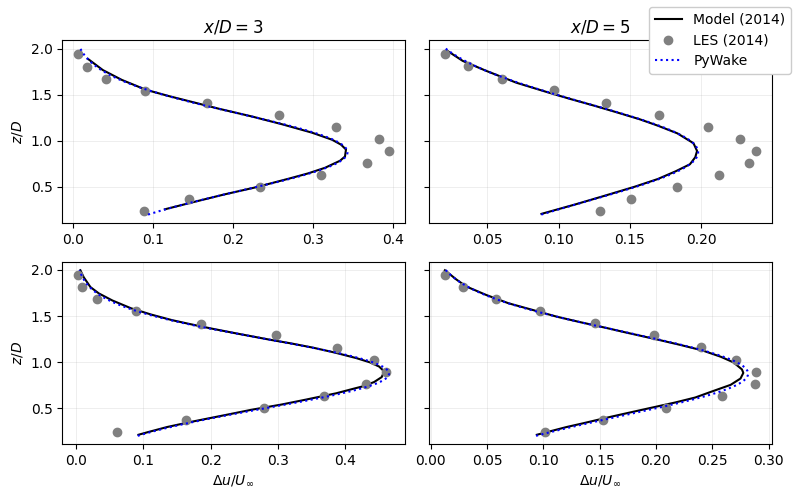

In [6]:
from py_wake.flow_map import XZGrid

# normal point distribution for plotting
zd = np.linspace(0.2, 2., 201)

# define wind turbine and site
wt = Dummy(ct=ct, d=d, zh=zh)
site = BastankhahSite(ws=ws)

fig, ax = plt.subplots(2, 2, sharey=True, figsize=(8, 5))
for i, (case, k) in enumerate(zip(cases, ks)):
    # wind farm model, you need to set the expansion factor, k
    wfm = Bastankhah_PorteAgel_2014(site, wt, k)
    # simulation
    sim = wfm(x=[0.], y=[0.], wd=270., ws=ws)
    # wake profiles
    u = np.squeeze(sim.flow_map(XZGrid(y=0.0, x=np.array(xd) * d, z=zd  * d)).WS_eff)
    for j in range(len(xd)):
        ax[i, j].plot(ref_fig7[case]['model'][:, j, 0], ref_fig7[case]['model'][:, j, 1], 'k-', label='Model (2014)')
        ax[i, j].plot(ref_fig7[case]['LES'][:, j, 0], ref_fig7[case]['LES'][:, j, 1], 'o', color=0.5 * np.ones(3), label='LES (2014)')
        ax[i, j].plot(1. - u[:, j] / ws, zd, 'b:', label='PyWake')
        if i == 0:
            ax[i, j].set_title(r'$x/D={:.0f}$'.format(xd[j]))
        if i == 1:
            ax[i, j].set_xlabel(r'$\Delta u/ U_{\infty}$')
        if j == 0:
            ax[i, j].set_ylabel(r'$z/D$')
        ax[i, j].grid(lw=0.5, alpha=0.3)
lines, labels = ax[0, 0].get_legend_handles_labels()
leg = fig.legend(lines, labels, loc='upper right')
leg.get_frame().set_alpha(1.0)
fig.tight_layout()

The agreement between PyWake and the paper is perfect, with any deviations being easily attributed to the manual extraction of data from the paper (the plot is rather small). 

## Niayifar and Porté-Agel (2016)

This section reproduces results from 

Niayifar A and Porté-Agel F.: _Analytical Modeling of Wind Farms: A New Approach for Power Prediction_, Energies, 9(9), 741, (2016), https://doi.org/10.3390/en9090741

This paper defines a wind farm model using the Gaussian wake model by Bastankhah and Porté-Agel (2014). Important additions are:

- inflow turbulence intensity depended wake expansion
- linear wake superposition


### Site and wind turbine

The paper presents results for Horns Rev 1, which are available in PyWake.

In [7]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80, wt_x, wt_y
v80_pw = V80()
site = Hornsrev1Site()

Unfortunatley it remains somewhat unclear what thrust and power curves the authors used for the Vestas V-80 in their simulations. Only after testing a lot of different possibilities were we able to reproduce their results.

They present a fitted power curve in Fig. 2, but also show 2 more pairs of curves in Fig. 4 (observed and predicted) without clearly stating which curves were exactly used. Here we show how much these different V-80 definitions differ and also compare it to the one in PyWake. From Fig. 4 only the curves labelled _predicted_ were extracted manually from the paper. In Fig. 2 no thrust curve has been defined so we used the one from Fig. 4, instead. Yet there is another issue in that case. The curves in Fig. 4 only start at a wind speed of 5 m/s, but the one in Fig. 4 starts at 4 m/s, the we take the $C_T$ from Fig. 4 but need to add another value at 4 m/s, which is simply set to the $C_T$ at 5 m/s.

In [8]:
# load reference data extracted manually from Fig.5 of the paper
dat = np.genfromtxt(os.path.join('data', 'Gaussian', 'Niayifar_PorteAgel_2016_Fig4.csv'),
                    skip_header=2, delimiter=',')

v80_2016_fig4 = WindTurbine(name="V80 (2016: Fig.4)", diameter=80., hub_height=70.,
                            powerCtFunction=PowerCtTabular(dat[:, 2], dat[:, 3], 'MW', dat[:, 1]), method='pchip')
# Fig. 2 provides a fit for power but not CT, so we take the CT from Fig. 4
# but need to add another value at 4 m/s, which is simply set to the CT at 5 m/s
ws = np.hstack((np.array([3.9, 4.0]), dat[1:, 2]))
ct = np.hstack((np.array([0.0, dat[1, 1]]), dat[1:, 1]))
power = (0.17819 * ws**5 - 6.5198 * ws**4 + 90.623 * ws**3 - 574.62 * ws**2 + 1727.2 * ws - 1975)
power[power > 2000.] = 2000.
power[ws < 4] = 0.0
power[ws > 20] = 0.0
v80_2016_fig2 = WindTurbine(name="V80 (2016: Fig.2)", diameter=80., hub_height=70.,
                            powerCtFunction=PowerCtTabular(ws, power, 'kW', ct), method='pchip')

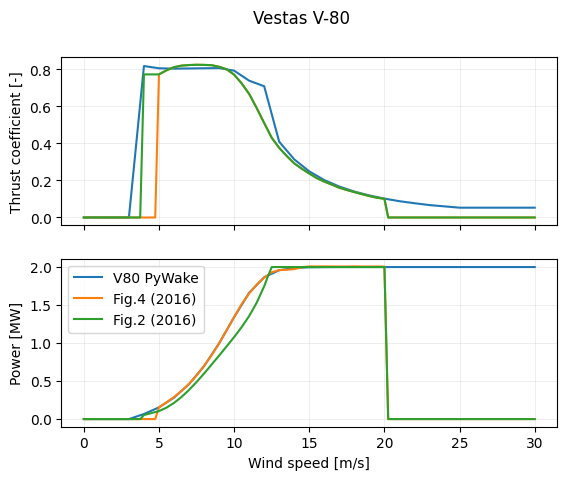

<Figure size 640x480 with 0 Axes>

In [9]:
from py_wake.utils.plotting import setup_plot

ws = np.linspace(0, 30, 121)

fig, ax = plt.subplots(2, 1, sharex=True)
plt.figure()
ax[0].plot(ws, v80_pw.ct(ws), '-', label='PyWake')
ax[0].plot(ws, v80_2016_fig4.ct(ws), '-', label='Fig.4 (2016)')
ax[0].plot(ws, v80_2016_fig2.ct(ws), '-', label='Fig.2 (2016)')
ax[0].grid(lw=0.5, alpha=0.3)
ax[0].set_ylabel('Thrust coefficient [-]')

ax[1].plot(ws, v80_pw.power(ws) / 1.e6, '-', label='V80 PyWake')
ax[1].plot(ws, v80_2016_fig4.power(ws) / 1.e6, '-', label='Fig.4 (2016)')
ax[1].plot(ws, v80_2016_fig2.power(ws) / 1.e6, '-', label='Fig.2 (2016)')
ax[1].grid(lw=0.5, alpha=0.3)
ax[1].set_ylabel('Power [MW]')
ax[1].set_xlabel('Wind speed [m/s]')
fig.suptitle('Vestas V-80')
ax[1].legend()

In the following plot we recreate Fig. 2 but adding the power curves from PyWake and Fig. 4 to show the difference between them. For some reason the power is lower in Fig. 2.

Text(0.5, 0, 'Wind speed [m/s]')

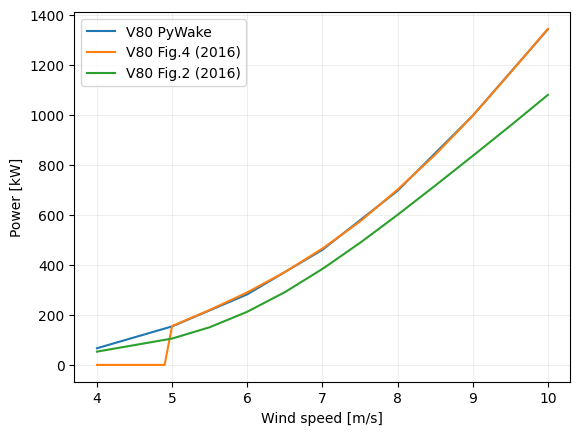

In [10]:
ws = np.linspace(4, 10, 121)
plt.figure()
plt.plot(ws, v80_pw.power(ws) / 1.e3, '-', label='V80 PyWake')
plt.plot(ws, v80_2016_fig4.power(ws) / 1.e3, '-', label='V80 Fig.4 (2016)')
plt.plot(ws, v80_2016_fig2.power(ws) / 1.e3, '-', label='V80 Fig.2 (2016)')
plt.legend()
plt.grid(lw=0.5, alpha=0.3)
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')

### Wind farm model

The wind farm model uses the Gaussian wake model together with linear wake deficit summation and a wake expansion factor that respionds to the local inflow turbulence intensity (TI). The added TI is computed using the model by Crespo and Hernandez (1996) with slightly modified constants. The square of the local TI is defined as the sum of the ambient TI and the maximum weighted (by wake-rotor overleap area) added TI.    

In [11]:
from py_wake.literature.gaussian_models import Niayifar_PorteAgel_2016

### Validation

**Case definition**

In [12]:
# hub height wind speed
ws = 8.0
# ambient turbulence intensity
ti = 0.077
# wind directions
wd = np.arange(173., 354., 1.)

**PyWake Simulation**

The paper does not cearly state how the rotor reference velocity is computed (used to scale the deficit and look-up the thrust and power). So here we try both, the PyWake default, which is the `RotorCenter()` method, and the `GaussianOverlapAvgModel()` (set as default in the literature model, but set here explicitly for clarity), which averages velocities over the rotor disc. This will also demonstrate how the rotor-averaging can influence your results. Furthermore, we test the different definitions of the Vestas V-80 given in the paper.  

In [13]:
from py_wake.rotor_avg_models import RotorCenter
from py_wake.rotor_avg_models.gaussian_overlap_model import GaussianOverlapAvgModel

# instantiate wind farm model
wfm_rc = Niayifar_PorteAgel_2016(site, v80_2016_fig4, rotorAvgModel=RotorCenter())
wfm_ga = Niayifar_PorteAgel_2016(site, v80_2016_fig4, rotorAvgModel=GaussianOverlapAvgModel())
wfm_ga_fig2 = Niayifar_PorteAgel_2016(site, v80_2016_fig2, rotorAvgModel=GaussianOverlapAvgModel())
# run simulation
sim_rc = wfm_rc(wt_x, wt_y, TI=ti, ws=ws, wd=wd)
sim_ga = wfm_ga(wt_x, wt_y, TI=ti, ws=ws, wd=wd)
sim_ga_fig2 = wfm_ga_fig2(wt_x, wt_y, TI=ti, ws=ws, wd=wd)

**Reproduction of Fig. 5**

This figure compares the wind farm efficieny predicted by LES simulations and the Gaussian wind farm model at a single wind speed. 

Load reference data

In [14]:
# load reference data extracted manually from Fig.5 of the paper
dat = np.genfromtxt(os.path.join('data', 'Gaussian', 'Niayifar_PorteAgel_2016_Fig5.csv'),
                    skip_header=2, delimiter=',')
ref_fig5 = {}
ref_fig5['LES'] = dat[:, :2]
ref_fig5['model'] = dat[:, 2:]

Plotting

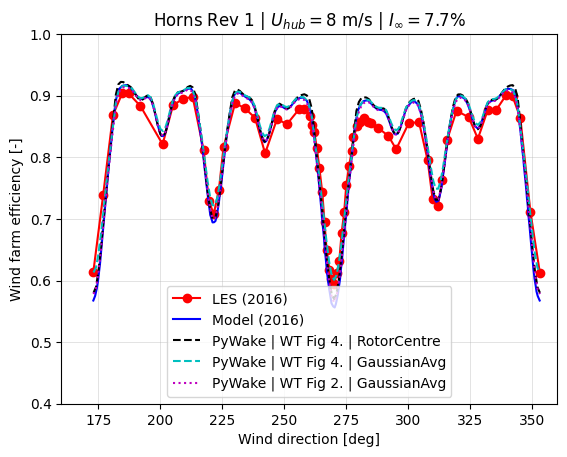

In [15]:
plt.figure()
plt.plot(ref_fig5['LES'][:, 0], ref_fig5['LES'][:, 1], 'ro-', label='LES (2016)')
plt.plot(ref_fig5['model'][:, 0], ref_fig5['model'][:, 1], 'b-', label='Model (2016)')
plt.plot(wd, sim_rc.Power.sum(axis=0)[:, 0] / (len(wt_x) * v80_2016_fig4.power(ws=ws)), 'k--', label='PyWake | WT Fig 4. | RotorCentre')
plt.plot(wd, sim_ga.Power.sum(axis=0)[:, 0] / (len(wt_x) * v80_2016_fig4.power(ws=ws)), 'c--', label='PyWake | WT Fig 4. | GaussianAvg')
plt.plot(wd, sim_ga_fig2.Power.sum(axis=0)[:, 0] / (len(wt_x) * v80_2016_fig2.power(ws=ws)), 'm:', label='PyWake | WT Fig 2. | GaussianAvg')
plt.axis([160, 360, 0.4, 1.0])
plt.xlabel('Wind direction [deg]')
plt.ylabel('Wind farm efficiency [-]')
plt.title('Horns Rev 1 | $U_{hub}=8$ m/s | $I_{\infty}=7.7$%')
plt.grid('on', lw=0.5, alpha=0.5)
plt.legend()

The agreement is nearly perfect. Interestingly using the `GaussianOverlapAvgModel()` the results are closer to the LES predictions when the turbine rows are aligning ie. in situations of full-wake.

**Reproduction Fig. 6**

This figure compares the power production evolution along a row of turbines for a wind direction of 270 degrees, constiuting a full-wake situation. 

Load reference data

In [16]:
# load reference data extracted manually from Fig.5 of the paper
dat = np.genfromtxt(os.path.join('data', 'Gaussian', 'Niayifar_PorteAgel_2016_Fig6.csv'),
                    skip_header=2, delimiter=',')
ref_fig6 = {}
ref_fig6['model'] = dat[:, :2]
ref_fig6['LES'] = dat[:, 2:]

The turbine numbering is different in the paper than in PyWake, but they mention that they average over columns 2, 3 and 4 (a column in the paper refers to turbine row spanning from east to west, with the southernmost being column 1). The following plot shows the turbine rows to be selected for the plot.  

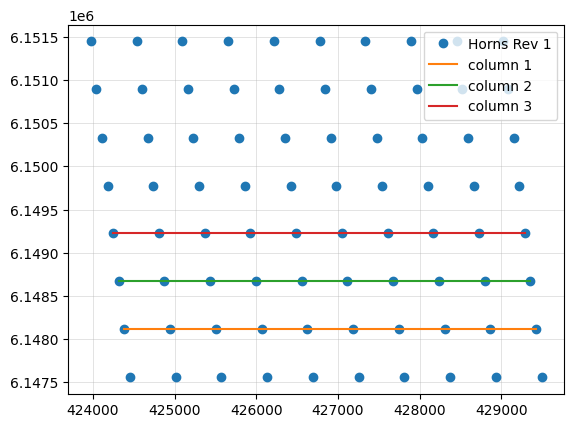

In [17]:
plt.figure()
plt.plot(wt_x, wt_y, 'o', label='Horns Rev 1')
for i in range(3):
    plt.plot(wt_x[8 - (i + 2)::8], wt_y[8 - (i + 2)::8], '-', label='column {}'.format(i + 1))
plt.grid('on', lw=0.5, alpha=0.5)
leg = plt.legend()

Plot Fig. 6

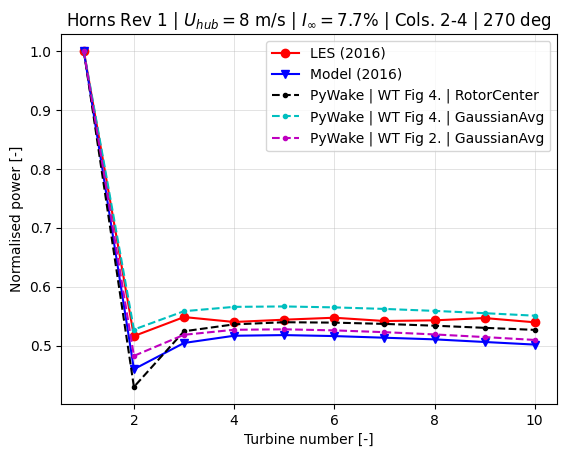

In [18]:
plt.figure()
iwt = np.linspace(1, 10, 10)
plt.plot(iwt, ref_fig6['LES'][:, 1], 'ro-', label='LES (2016)')
plt.plot(iwt, ref_fig6['model'][:, 1], 'bv-', label='Model (2016)')

# select wind direction 270 degrees
iwd = 97
# select columns
pp = np.zeros((3, 10, 3))
for i in range(pp.shape[0]):
    pp[i, :, 0] = sim_rc.Power.values[8 - (i + 2)::8, iwd, 0]
    pp[i, :, 1] = sim_ga.Power.values[8 - (i + 2)::8, iwd, 0]
    pp[i, :, 2] = sim_ga_fig2.Power.values[8 - (i + 2)::8, iwd, 0]
# average over columns
pp_avg = np.mean(pp, axis=0)
# plot results
plt.plot(iwt, pp_avg[:, 0] / pp_avg[0, 0], 'k.--', label='PyWake | WT Fig 4. | RotorCenter')
plt.plot(iwt, pp_avg[:, 1] / pp_avg[0, 1], 'c.--', label='PyWake | WT Fig 4. | GaussianAvg')
plt.plot(iwt, pp_avg[:, 2] / pp_avg[0, 2], 'm.--', label='PyWake | WT Fig 2. | GaussianAvg')

plt.xlabel('Turbine number [-]')
plt.ylabel('Normalised power [-]')
plt.title('Horns Rev 1 | $U_{hub}=8$ m/s | $I_{\infty}=7.7$% | Cols. 2-4 | ' + '{:.0f} deg'.format(sim_ga.wd.values[iwd]))
plt.grid('on', lw=0.5, alpha=0.5)
plt.legend()

Following some detective work, it seems that some sort of rotor-averaging was indeed used by the authors, as indicated by the PyWake curves with `GaussianOverlapAvgModel()` having similar shapes. The slight offset between PyWake and the results from the paper might be due to differences in the thrust curve, specific rotor-averaging method used or related to the manual extraction of the data from the figure. 

## Carbajo Fuertes et al. (2018)

This section presents our implementation of the modifications presented in

Carbajo Fuertes, F., Markfort, C. D., & Porté-Agel, F.: _Wind turbine wake characterization with nacelle-mounted wind lidars for analytical wake model validation_, Remote Sensing, 10(5), 668, (2018), https://doi.org/10.3390/rs10050668

to the Gaussian model by Niayifar et al. (2016). In this paper they use wind lidar measurements taken in the wake of a 2.5MW turbine to retune the expression for the wake width, $\sigma$, in the Gaussian model. An important change is that the initial wake width, $\epsilon$, becomes a function of the wake expansion rate, $k$, and thereby becomes dependant on turbulence intensity.    

### Comparison 

To show the impact of the modification we rerun the Horns Rev 1 case used by Niayifar and PorteAgel (2016).

In [19]:
from py_wake.literature.gaussian_models import CarbajoFuertes_etal_2018

# instantiate
wfm_16 = Niayifar_PorteAgel_2016(site, v80_2016_fig2)
wfm_18 = CarbajoFuertes_etal_2018(site, v80_2016_fig2)

# run simulation
sim_16 = wfm_16(wt_x, wt_y, TI=ti, ws=ws, wd=wd)
sim_18 = wfm_18(wt_x, wt_y, TI=ti, ws=ws, wd=wd)

Wind farm efficiency

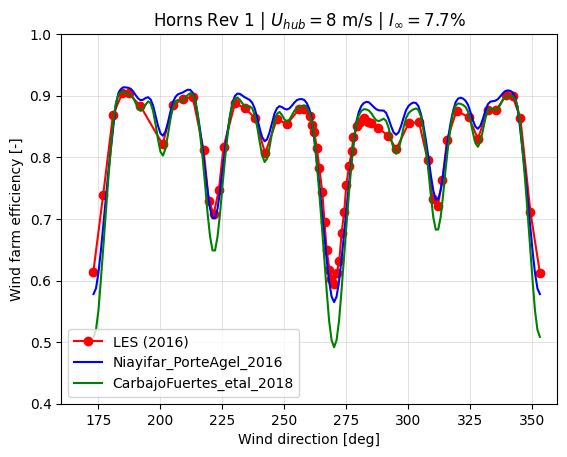

In [20]:
plt.figure()
plt.plot(ref_fig5['LES'][:, 0], ref_fig5['LES'][:, 1], 'ro-', label='LES (2016)')
plt.plot(wd, sim_16.Power.sum(axis=0)[:, 0] / (len(wt_x) * v80_2016_fig2.power(ws=ws)), 'b-', label='Niayifar_PorteAgel_2016')
plt.plot(wd, sim_18.Power.sum(axis=0)[:, 0] / (len(wt_x) * v80_2016_fig2.power(ws=ws)), 'g-', label='CarbajoFuertes_etal_2018')
plt.axis([160, 360, 0.4, 1.0])
plt.xlabel('Wind direction [deg]')
plt.ylabel('Wind farm efficiency [-]')
plt.title('Horns Rev 1 | $U_{hub}=8$ m/s | $I_{\infty}=7.7$%')
plt.grid('on', lw=0.5, alpha=0.5)
plt.legend()

Power variation

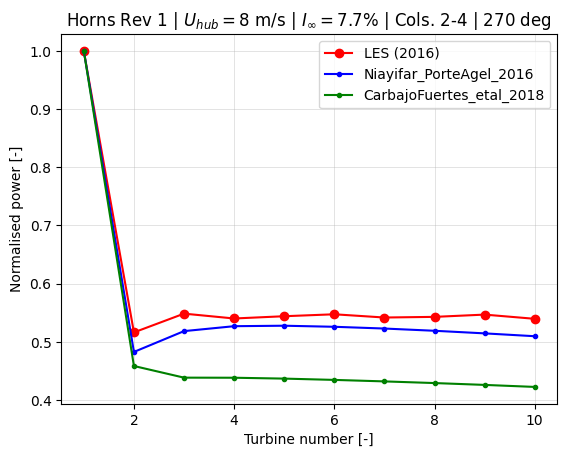

In [21]:
plt.figure()
iwt = np.linspace(1, 10, 10)
plt.plot(iwt, ref_fig6['LES'][:, 1], 'ro-', label='LES (2016)')

# select wind direction 270 degrees
iwd = 97
# select columns
pp = np.zeros((3, 10, 3))
for i in range(pp.shape[0]):
    pp[i, :, 0] = sim_16.Power.values[8 - (i + 2)::8, iwd, 0]
    pp[i, :, 1] = sim_18.Power.values[8 - (i + 2)::8, iwd, 0]
# average over columns
pp_avg = np.mean(pp, axis=0)
# plot results
plt.plot(iwt, pp_avg[:, 0] / pp_avg[0, 0], 'b.-', label='Niayifar_PorteAgel_2016')
plt.plot(iwt, pp_avg[:, 1] / pp_avg[0, 1], 'g.-', label='CarbajoFuertes_etal_2018')

plt.xlabel('Turbine number [-]')
plt.ylabel('Normalised power [-]')
plt.title('Horns Rev 1 | $U_{hub}=8$ m/s | $I_{\infty}=7.7$% | Cols. 2-4 | ' + '{:.0f} deg'.format(sim_16.wd.values[iwd]))
plt.grid('on', lw=0.5, alpha=0.5)
plt.legend()

For aligned, deep-wake situations the updates to the model seem to overpredict losses, yet in any other situation it provides efficiency estimates close to the LES simulations.

## Zong and Porté-Agel (2020)

This section reproduces results from 

Zong H. and Porté-Agel F.: _A momentum-conserving wake superposition
method for wind farm power prediction_, J. Fluid Mech., 889, A8, (2020), https://doi.org/10.1017/jfm.2020.77

The main focus of this paper is a momentum-conserving wake superposition model, however it also presents yet another version of a Gaussian model. Indeed without modifying the near-wake behaviour of the original Guassian model, the superposition model leads to bizarre results in the near-wake region. 

Extension of the Niayifar et al. (2016) implementation with adapted
Shapiro wake model components, namely a gradual growth of the thrust
force and an expansion factor not falling below the rotor diameter.
Shapiro modelled the pressure and thrust force as a combined momentum
source, that are distributed in the streamwise direction with a Gaussian
kernel with a certain characteristic length. As a result the induction
changes following an error function. Zong chose to use a characteristic
length of $D/\sqrt{2}$ and applies it directly to the thrust not the induction
as Shapiro. This leads to the full thrust being active only $2D$ downstream of
the turbine. Zong's wake width expression is inspired by Shapiro's, however
the start of the linear wake expansion region (far-wake) was related to
the near-wake length by Vermeulen (1980). The initial wake width, $\epsilon$, in the
original Gaussian model was taken to be a function of $C_T$ is now a constant
as proposed by Bastankhah et al. (2016), as the near-wake length now effectively
dictates the origin of the far-wake.

### Validation

**Fig. 3 reproduction**

This reproduces the results from a wind tunnel measurement campaign with four aligned miniature wind turbines.

Case definitions

In [22]:
# hub height wind speed
ws = 4.9
# rotor diameter
d = .15
# rotor hub height
zh = 0.125
# rotor thrust coefficient
ct = 0.82
# turbulence intensity
ti = 0.06
# turbine tip speed ratio needed in near-wake length computation (personal communication)
lam = 3.8

Instantiate site and wind turbine

In [23]:
# define wind turbine and site
wt = Dummy(ct=ct, d=d, zh=zh)
site = BastankhahSite(ws=ws, ti=ti)

# turbine positions
wt_y = [0., 0., 0., 0.]
wt_x = [0., 5. * d, 10. * d, 15. * d]

As in the paper we will run PyWake with different superposition models. Note how both `effective_ws` and `effective_ti` need to be set to `False` to reproduce what Zong et al. refer to as the one by Katic et al. or Method B in their paper. By default the superposition method by Zong is used, which in PyWake is called `WeightedSum()`, as it weights deficits using the convection velocity ratio.

In [28]:
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020
from py_wake.superposition_models import LinearSum, SquaredSum
from py_wake.flow_map import Points
from py_wake.rotor_avg_models import CGIRotorAvg

wfm_names = ['SquaredSum', 'LinearSum', 'WeightedSum']

wfms = [Zong_PorteAgel_2020(site, wt, lam=lam,
                            superpositionModel=SquaredSum(),
                            rotorAvgModel=GaussianOverlapAvgModel(),
                            use_effective_ws=False, use_effective_ti=False),
        Zong_PorteAgel_2020(site, wt, lam=lam,
                            superpositionModel=LinearSum(),
                            rotorAvgModel=GaussianOverlapAvgModel()),
        Zong_PorteAgel_2020(site, wt, lam=lam,
                            rotorAvgModel=CGIRotorAvg(21))]

Load reference data, provided by the authors

In [29]:
# load reference data extracted manually from Fig.5 of the paper
ref_fig3 = np.genfromtxt(os.path.join('data', 'Gaussian', 'Zong_PorteAgel_2020_Fig3.csv'),
                         skip_header=1, delimiter=',')

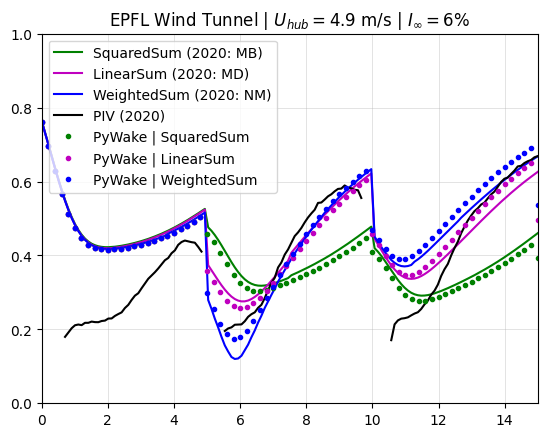

In [30]:

plt.figure()

# Reference data
plt.plot(ref_fig3[:, 0], ref_fig3[:, 2], 'g-', label='SquaredSum (2020: MB)')
plt.plot(ref_fig3[:, 0], ref_fig3[:, 3], 'm-', label='LinearSum (2020: MD)')
plt.plot(ref_fig3[:, 0], ref_fig3[:, 5], 'b-', label='WeightedSum (2020: NM)')
plt.plot(ref_fig3[:, 0], ref_fig3[:, 6], 'k-', label='PIV (2020)')

# PyWake
x = np.linspace(0, 15, 5 * 15 + 1) * d
lcs = ['g', 'm', 'b']
for wfm, wfm_name, lc in zip(wfms, wfm_names, lcs):
    sim = wfm(wt_x, wt_y, ws=ws, wd=270., TI=ti)
    u = np.squeeze(sim.flow_map(Points(x=x, y=np.zeros_like(x), h=zh * np.ones_like(x))).WS_eff.values)
    plt.plot(x / d, u / ws, lc + '.', label='PyWake | ' + wfm_name)

plt.title('EPFL Wind Tunnel | $U_{hub}=4.9$ m/s | $I_{\infty}=' + '{:.0f}$%'.format(ti * 1.e2))
plt.grid('on', lw=0.5, alpha=0.5)
plt.axis([0., 15., 0., 1.0])
plt.legend()

The Zong wake deficit is correctly implemented as demonstrated by near-perfect match in the wake of the first turbine. The wake growth seems a little slower, but without knowing the exact expression used for the near-wake length (here we use the one presented by Niayifar et al. (2016) in Eq.(11)) it is difficult to get exactly the same (one can increase $I_{\infty}$ ever so slightly and they will line-up). After the second turbine there are slight differences between the classic superposition models, most likely due differences in the rotor-averaging method (not disclosed in the paper). 